In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

IDIR = 'data/'

In [2]:
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv',
                     dtype={
                         'order_id': np.int32,
                         'product_id': np.uint16,
                         'add_to_cart_order': np.int16,
                         'reordered': np.int8},
                     nrows=1000000)

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv',
                    dtype={
                        'order_id': np.int32,
                        'product_id': np.uint16,
                        'add_to_cart_order': np.int16,
                        'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv',
                     dtype={
                         'order_id': np.int32,
                         'user_id': np.int32,
                         'eval_set': 'category',
                         'order_number': np.int16,
                         'order_dow': np.int8,
                         'order_hour_of_day': np.int8,
                         'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv(IDIR + 'products.csv',
                       dtype={
                           'product_id': np.uint16,
                           'order_id': np.int32,
                           'aisle_id': np.uint8,
                           'department_id': np.uint8},
                       usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

loading prior
loading train
loading orders
loading products
priors (1000000, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


In [3]:
print('computing product f')

prods = pd.DataFrame()

prods['orders'] = priors.groupby(priors['product_id']).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors['product_id']).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)

products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)

del prods

computing product f


In [4]:
print('add order info to priors')

orders.set_index('order_id', inplace=True, drop=False)

priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

add order info to priors


In [5]:
print('computing user f')
usr = pd.DataFrame()

usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('user f', users.shape)

computing user f
user f (67036, 6)


In [6]:
print('compute userXproduct f - this is long...')
priors['user_product'] = priors.product_id + priors.user_id * 100000

d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d

compute userXproduct f - this is long...
to dataframe (less memory)


In [7]:
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

del priors

user X product f 913849


In [8]:
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

split orders : train, test


In [9]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        
        if not user_id in users.all_products:
            continue
            
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]

    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list

    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)

    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders

    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [10]:
df_train, labels = features(train_orders, labels_given=True)

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_or

In [11]:
#pd.options.display.max_columns = 20
pd.options.display.max_columns = 999
df_train.head(15)

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,525192,11520,21,11,11,10.450000,0.523810,11,6.0,0.574163,86,16,1224,934.0,0.763072,1,0.047619,9.0,0.047619,4,1
1,525192,37602,21,11,11,10.450000,0.523810,11,6.0,0.574163,26,7,20,15.0,0.750000,1,0.047619,4.0,0.047619,4,1
2,525192,17638,21,11,11,10.450000,0.523810,11,6.0,0.574163,26,7,68,51.0,0.750000,1,0.047619,8.0,0.047619,4,1
3,525192,13198,21,11,11,10.450000,0.523810,11,6.0,0.574163,122,12,379,241.0,0.635884,1,0.047619,1.0,0.047619,4,1
4,525192,27344,21,11,11,10.450000,0.523810,11,6.0,0.574163,96,20,1294,849.0,0.656105,1,0.047619,11.0,0.047619,4,1
5,525192,4945,21,11,11,10.450000,0.523810,11,6.0,0.574163,123,4,168,123.0,0.732143,1,0.047619,7.0,0.047619,4,1
6,525192,32177,21,11,11,10.450000,0.523810,11,6.0,0.574163,24,4,321,146.0,0.454829,1,0.047619,10.0,0.047619,4,1
7,525192,42803,21,11,11,10.450000,0.523810,11,6.0,0.574163,50,19,201,147.0,0.731343,1,0.047619,2.0,0.047619,4,1
8,525192,40852,21,11,11,10.450000,0.523810,11,6.0,0.574163,91,16,133,109.0,0.819549,1,0.047619,5.0,0.047619,4,1
9,525192,8277,21,11,11,10.450000,0.523810,11,6.0,0.574163,24,4,2625,1953.0,0.744000,1,0.047619,3.0,0.047619,4,1


In [12]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'


print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
del df_train

formating for lgb


In [13]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)

del d_train

light GBM train :-)


/home/fausto/.local/lib/python3.5/site-packages/lightgbm/basic.py:986: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


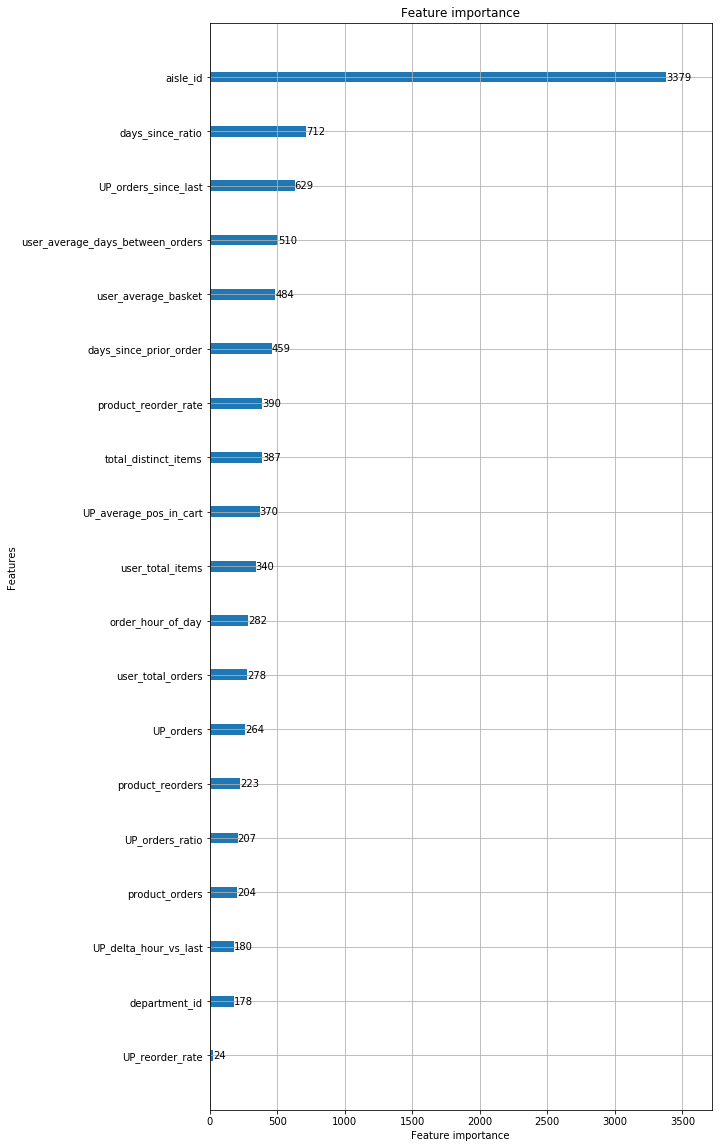

In [14]:
lgb.plot_importance(bst, figsize=(9,20))
plt.show()

In [15]:
df_test, _ = features(test_orders)

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in

In [16]:
d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)